In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

from matplotlib.patches import Rectangle

import pandas as pd
import numpy as np
import cupy as cp
import cv2

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

# Model definition

In [3]:
env_x = [-2,10]
env_y = [-1,1]
points_per_unit = 30

width = ((env_x[1] - env_x[0]) * points_per_unit) + 1
height = ((env_y[1] - env_y[0]) * points_per_unit) + 1

env_shape = [height, width]
state_count = width * height
print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: [61, 361]
State count: 22021


In [4]:
# Data loading
nose_data = pd.read_csv('./Data/statistics_abs_nose_3e6.dat', sep=' ', skiprows=[0], names=list(range(320)), index_col=False).to_numpy().T
ground_data = pd.read_csv('./Data/statistics_abs_ground_3e6.dat', sep=' ', skiprows=[0], names=list(range(320)), index_col=False).to_numpy().T

nose_data = cv2.resize(nose_data, dsize=((4 * points_per_unit) + 1, points_per_unit + 1))
ground_data = cv2.resize(ground_data, dsize=((4 * points_per_unit) + 1, points_per_unit + 1))

nose_data_padded = np.zeros(env_shape)
nose_data_padded[15:46, 60:181] = nose_data

ground_data_padded = np.zeros(env_shape)
ground_data_padded[15:46, 60:181] = ground_data

nose_data = nose_data_padded
ground_data = ground_data_padded

In [5]:
# goal state
goal_state_coords = [30,60]
goal_state = (goal_state_coords[0] * env_shape[1]) + goal_state_coords[1]

print(f'Goal state: {goal_state}')

Goal state: 10890


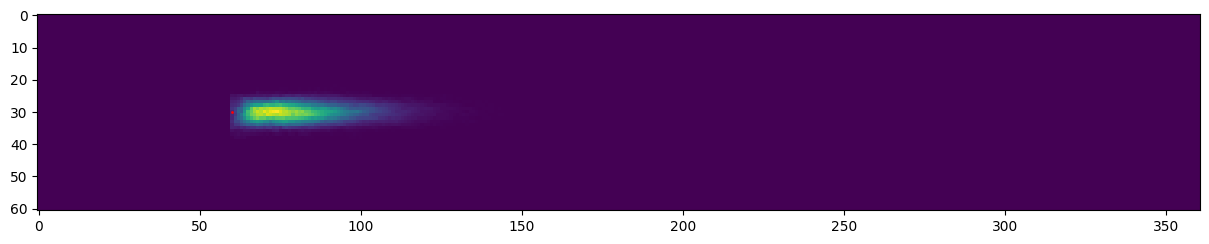

In [6]:
plt.figure(figsize=(15,5))
plt.imshow(ground_data)
plt.scatter(goal_state_coords[1], goal_state_coords[0], c='red',s=1)

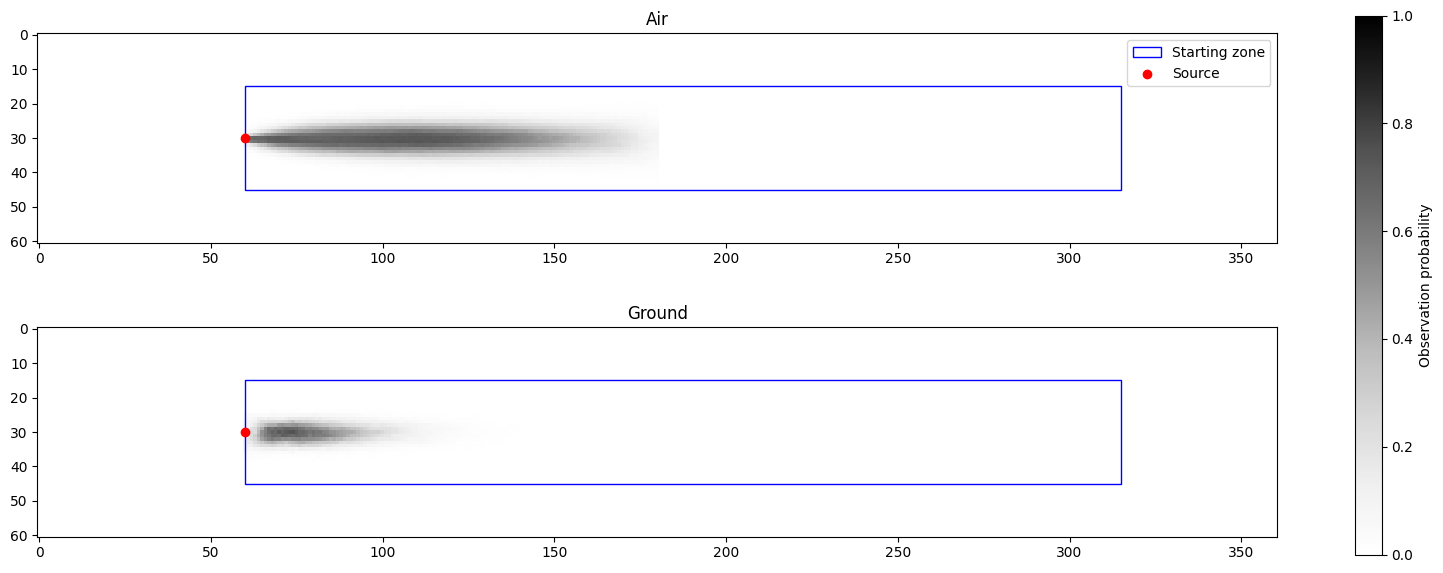

In [7]:
fig, (ax_a, ax_g) = plt.subplots(2, 1, figsize=(20,7))

min_x = 60
min_y = 15
width = 8.5*30
height = 30

ax_a.set_title('Air')
im = ax_a.imshow(nose_data, vmax=1, vmin=0, cmap='Greys')
ax_a.add_patch(Rectangle([min_x, min_y], width, height, linewidth=1, edgecolor='b', facecolor='none', label='Starting zone'))
ax_a.scatter(x=60, y=30, color='red', label='Source')
ax_a.legend()

ax_g.set_title('Ground')
im = ax_g.imshow(ground_data, vmax=1, vmin=0, cmap='Greys')
ax_g.add_patch(Rectangle([min_x, min_y], width, height, linewidth=1, edgecolor='b', facecolor='none'))
ax_g.scatter(x=60, y=30, color='red')

cbar = plt.colorbar(im, ax=[ax_g,ax_a])
cbar.set_label('Observation probability')

In [13]:
np.max(nose_data)

0.7391116678352441

[]

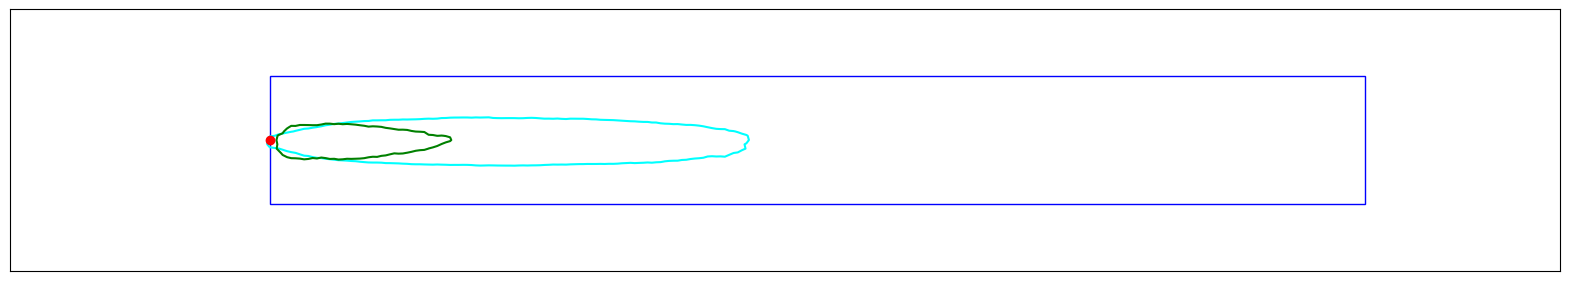

In [26]:
fig, ax = plt.subplots(1, figsize=(20,8))

min_x = 60
min_y = 15
width = 8.5*30
height = 30

im = ax.imshow(np.zeros(nose_data.shape), vmax=1, vmin=0, cmap='Greys')

ax.contour(nose_data, levels=[0.2], colors=['Cyan'])
ax.contour(ground_data, levels=[0.2], colors=['Green'])

ax.add_patch(Rectangle([min_x, min_y], width, height, linewidth=1, edgecolor='b', facecolor='none', label='Starting zone'))
ax.scatter(x=60, y=30, color='red', label='Source', zorder=10)

ax.set_xticks([])
ax.set_yticks([])

In [8]:
# observation matrix
observations = np.empty((state_count, 6, 3)) # 6-actions, 3-observations

# obs 0: Nothing observed, obs 1: Something observed, obs 2: source found

observations[:,:5,0] = (1 - ground_data.ravel()[:,None])
observations[:,:5,1] = ground_data.ravel()[:,None]

observations[:,5,0] = (1 - nose_data.ravel())
observations[:,5,1] = nose_data.ravel()

# Detection of goal
observations[:,:,2] = 0.0
observations[goal_state,:,:] = 0.0
observations[goal_state,:,2] = 1.0

In [9]:
# states
state_grid = []

# State labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [10]:
# Reachable states
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 6, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else (state_count - row_w) + s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s - (row_w - 1) # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s % row_w # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s + row_w - 1 # West
    reachable_states[s,4,0] = s # Doesn't move and sniff ground
    reachable_states[s,5,0] = s # Doesn't move and sniff air

reachable_states = np.array(reachable_states)

In [11]:
# Reward function
def reward_func(s,a,sn,o):
    return np.where(sn == goal_state, 1.0, 0.0)

In [12]:
# Start belief
start = np.zeros(env_shape)
start[15:46,60:316] = 1.0
start /= np.sum(start)

In [13]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W','O_Ground','O_Air'],
    observations=['nothing','something','goal'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[goal_state],
    start_probabilities=start.ravel()
)

[12/14/2023, 16:45:55] Instantiation of MDP Model:
[12/14/2023, 16:45:55] - 22021 states
[12/14/2023, 16:45:55] - 6 actions
[12/14/2023, 16:45:55] - At most 1 reachable states per state-action pair
[12/14/2023, 16:45:55] - Starting generation of transitions table
[12/14/2023, 16:45:55]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[12/14/2023, 16:45:55]     > Done in 0.000s
[12/14/2023, 16:45:55] - Generation of state grid
[12/14/2023, 16:45:55] - Generating start probabilities table
[12/14/2023, 16:45:55] - Starting computation of reachable state probabilities from transition data
[12/14/2023, 16:45:55]     > Done in 0.001s

[12/14/2023, 16:45:55] POMDP particular parameters:
[12/14/2023, 16:45:55] - 3 observations
[12/14/2023, 16:45:55] - Starting of transitional observations for reachable states table
[12/14/2023, 16:45:55]     > Done in 0.006s
[12/14/2

In [14]:
# model.save('Alt_Wrap_GroundAir')

# MDP solution

In [36]:
vi_solver = VI_Solver(eps=1e-6)
mdp_solution, hist = vi_solver.solve(model, use_gpu=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [50]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 22021-state, 6-action
  - Converged in 918 iterations and 0.9145 seconds
  - Took on average 0.0010s per iteration


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


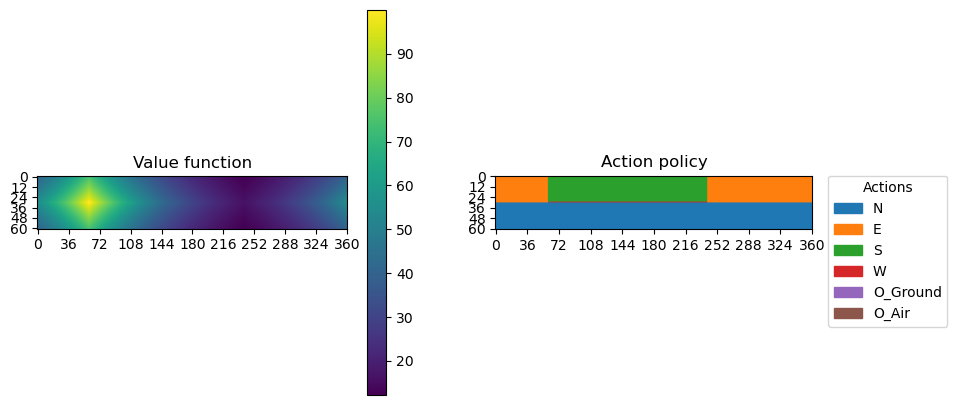

In [37]:
mdp_solution.plot()

In [38]:
vf = mdp_solution.to_cpu()

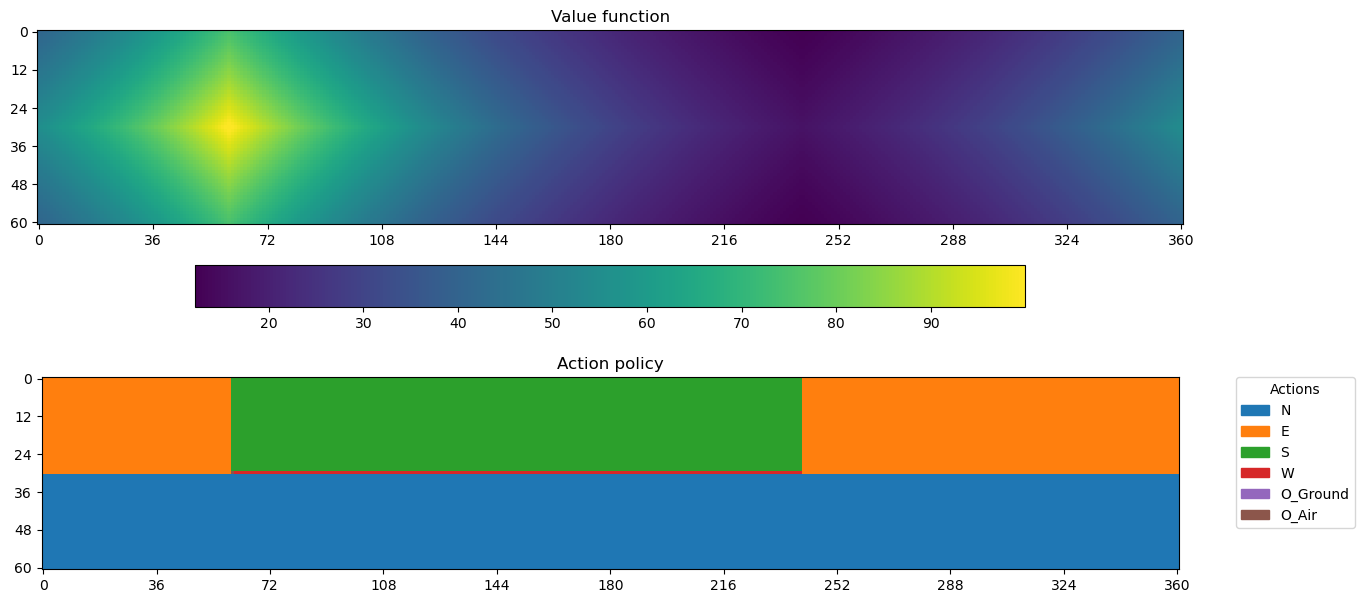

In [49]:
value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid]
best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid]
best_action_colors = COLOR_ARRAY[best_action_table]

dimensions = vf.model.state_grid.shape

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,7), height_ratios=(0.59,0.41))
plt.subplots_adjust(hspace=0.3)

# Ticks
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

ax1.set_title('Value function')
ax1_plot = ax1.imshow(value_table)
plt.colorbar(ax1_plot, ax=ax1, orientation='horizontal')
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

ax2.set_title('Action policy')
ax2.imshow(best_action_colors)
p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)

# Perseus Solving

In [14]:
perseus_solver = PBVI_Solver(0.99, 1e-6, 'perseus')
perseus_solution, hist = perseus_solver.solve(model=model,
                                              expansions=300,
                                              max_belief_growth=100,
                                              use_gpu=True)
print(hist.summary)

[12/01/2023, 13:50:12] Sending Model to GPU...


[12/01/2023, 13:50:12]     > Done in 0.235s
[12/01/2023, 13:50:12] [Warning] MDP solution not provided, running value iteration on the problem to retrieve it...
[12/01/2023, 13:50:12]     > Starting MDP Value Iteration...
[12/01/2023, 13:50:13]     > Value Iteration stopped or converged in 0.906s, and after 918 iteration.



Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


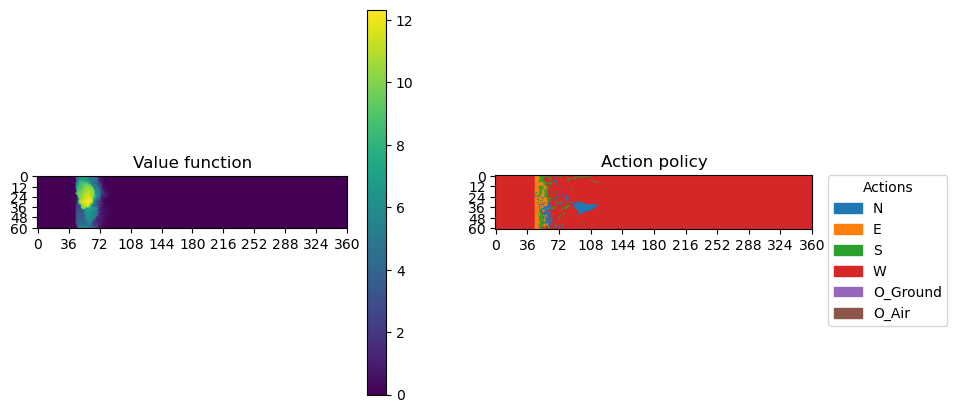

In [15]:
perseus_solution.plot()

In [16]:
a = Agent(model, perseus_solution)
rewards, all_sim = a.run_n_simulations_parallel()

  0%|          | 0/1000 [00:00<?, ?it/s]

All 1000 simulations done in 105.808s:
	- Simulations reached goal: 571/1000 (429 failures)
	- Average step count: 999.725
	- Average total rewards: 0.571
	- Average discounted rewards (ADR): 0.1221212221007784


In [17]:
from util_functions import compute_extra_steps
extra_steps = compute_extra_steps(all_sim)

# FSVI Solving

In [21]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [22]:
fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        expansions=300,
                                        max_belief_growth=100,
                                        # prune_level=2, # Useless because of belief domination
                                        # prune_interval=25,
                                        # history_tracking_level=2,
                                        use_gpu=True)
print(hist.summary)

[12/04/2023, 13:57:34] Sending Model to GPU...
[12/04/2023, 13:57:34]     > Done in 0.236s
[12/04/2023, 13:57:34] [Warning] MDP solution not provided, running value iteration on the problem to retrieve it...
[12/04/2023, 13:57:34]     > Starting MDP Value Iteration...
[12/04/2023, 13:57:35]     > Value Iteration stopped or converged in 0.868s, and after 918 iteration.



Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 22021 state, 6 action, 3 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 6875 alpha vectors.
  - Converged in 204.8851s

  - Expand function took on average 0.0523s and yielded on average 83.52 beliefs per iteration. (0.0006s/it/belief)
  - Backup function took on average 0.6306s and yielded on average 22.90 alpha vectors per iteration. (0.0003s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


In [19]:
fsvi_solution.save()

In [16]:
fsvi_solution = ValueFunction.load_from_file('./ValueFunctions/20231115_fsvi_g0.99_i300_e100_value_function_wrap.csv.gzip', model=model)

# History stats plot

In [23]:
hist_df = pd.DataFrame({
    'backup_times': [0.0] + hist.backup_times,
    'expand_times': [0.0] + hist.expansion_times,
    'alpha_vector_counts': hist.alpha_vector_counts,
    'belief_counts': hist.beliefs_counts
})

In [24]:
hist_df.to_csv('./Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/single_run_stats_2.csv')

In [45]:
trend_1_diff = hist.backup_times[9] - hist.backup_times[8]

In [46]:
trend_1_diff

0.0003049999999999997

In [34]:
hist.backup_times[:10]

[0.47415,
 0.005444,
 0.014033,
 0.013896,
 0.013489,
 0.014853,
 0.01251,
 0.015721,
 0.015994,
 0.016299]

array([ 0.0015003 , -0.00354434])

Text(0, 0.5, 'Runtime (s)')

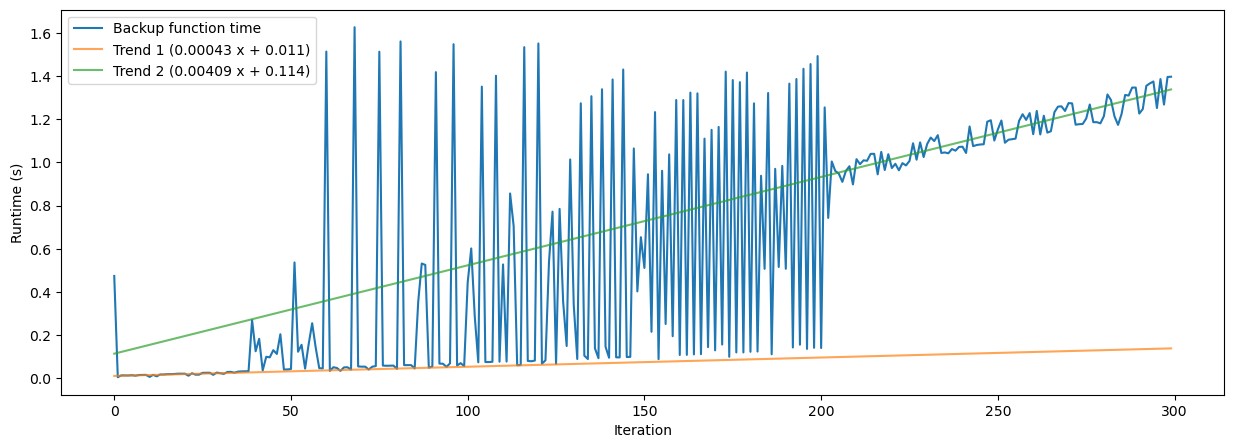

In [59]:
plt.figure(figsize=(15,5))

x = np.arange(300)

plt.plot(x, hist.backup_times, label='Backup function time')

trend_1 = np.polyfit(x[2:30],hist.backup_times[2:30],1)
plt.plot(x, (x*trend_1[0])+trend_1[1], alpha=0.7, label=f'Trend 1 ({trend_1[0]:.5f} x + {trend_1[1]:.3f})')

trend_2 = np.polyfit(x[210:270],hist.backup_times[210:270],1)
plt.plot(x, (x*trend_2[0])+trend_2[1], alpha=0.7, label=f'Trend 2 ({trend_2[0]:.5f} x + {trend_2[1]:.3f})')

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Runtime (s)')

Text(0, 0.5, 'Runtime (s)')

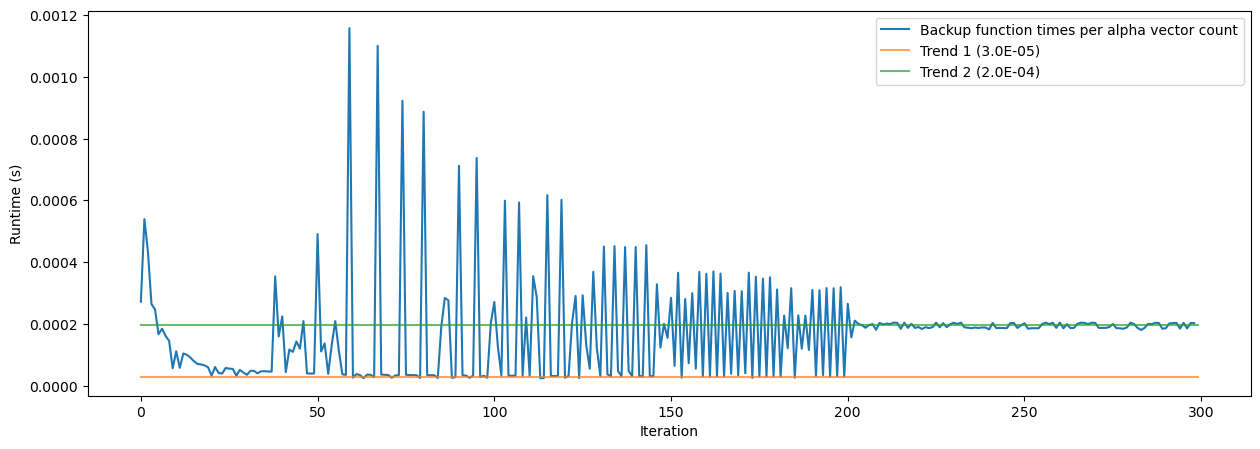

In [75]:
plt.figure(figsize=(15,5))

plt.plot(np.arange(299), np.array(hist.backup_times)[1:] / np.array(hist.alpha_vector_counts[2:]), label='Backup function times per alpha vector count')

trend_1 = np.polyfit(x[20:30], np.array(hist.backup_times[20:30]) / np.array(hist.alpha_vector_counts[21:31]), 1)
trend_1[1] = 30e-6
plt.plot(x, np.ones(len(x)) * trend_1[1], alpha=0.7, label=f'Trend 1 ({trend_1[1]:.1E})')

trend_2 = np.polyfit(x[210:270], np.array(hist.backup_times[210:270]) / np.array(hist.alpha_vector_counts[211:271]), 1)
plt.plot(x, np.ones(len(x)) * trend_2[1], alpha=0.7, label=f'Trend 2 ({trend_2[1]:.1E})')

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Runtime (s)')

# CPU FSVI run

In [14]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

fsvi_solution, cpu_hist = fsvi_solver.solve(model=model,
                                        expansions=300,
                                        max_belief_growth=100,
                                        # prune_level=2, # Useless because of belief domination
                                        # prune_interval=25,
                                        # history_tracking_level=2,
                                        use_gpu=False)
print(cpu_hist.summary)

[12/04/2023, 12:55:38] [Warning] MDP solution not provided, running value iteration on the problem to retrieve it...
[12/04/2023, 12:55:38]     > Starting MDP Value Iteration...
[12/04/2023, 12:55:39]     > Value Iteration stopped or converged in 0.919s, and after 918 iteration.



Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 22021 state, 6 action, 3 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 7882 alpha vectors.
  - Converged in 2983.4668s

  - Expand function took on average 0.0143s and yielded on average 81.73 beliefs per iteration. (0.0002s/it/belief)
  - Backup function took on average 9.9306s and yielded on average 26.26 alpha vectors per iteration. (0.0029s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


In [15]:
cpu_hist_df = pd.DataFrame({
    'backup_times': [0.0] + cpu_hist.backup_times,
    'expand_times': [0.0] + cpu_hist.expansion_times,
    'alpha_vector_counts': cpu_hist.alpha_vector_counts,
    'belief_counts': cpu_hist.beliefs_counts
})
cpu_hist_df.to_csv('./Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/single_run_CPU_stats.csv')

In [81]:
cpu_hist_df = pd.read_csv('./Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/single_run_CPU_stats.csv', index_col=0)

In [82]:
cpu_hist_df

,backup_times,expand_times,alpha_vector_counts,belief_counts
0,0.000000,0.000000,5,1
1,0.166119,0.010406,11,37
2,0.326426,0.034506,24,81
3,0.209312,0.043123,32,18
4,0.458009,0.023968,39,101
...,...,...,...,...
296,21.144144,0.013111,7810,81
297,21.473910,0.005575,7822,101
298,21.577541,0.005631,7828,101
299,21.660621,0.025721,7874,101


In [83]:
cpu_backup_times = cpu_hist_df['backup_times'].to_list()[1:]
# cpu_backup_times = cpu_hist.backup_times

Text(0, 0.5, 'Runtime (s)')

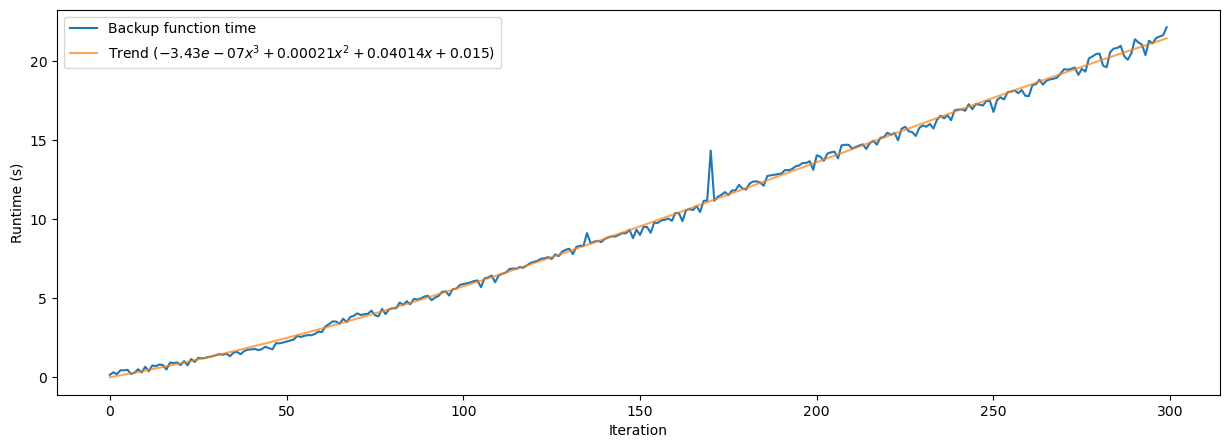

In [99]:
plt.figure(figsize=(15,5))

x = np.arange(300)

plt.plot(x, cpu_backup_times, label='Backup function time')

trend_1 = np.polyfit(x[:300], cpu_backup_times[:300], 3)
plt.plot(x, ((x**3)*trend_1[0]) + ((x**2)*trend_1[1]) + (x*trend_1[2]) + trend_1[3], alpha=0.7, 
         label=f'Trend (${trend_1[0]:.2e} x^3 + {trend_1[1]:.5f} x^2 + {trend_1[2]:.5f} x + {trend_1[3]:.3f}$)')

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Runtime (s)')

In [103]:
cpu_alpha_vector_counts = cpu_hist_df['alpha_vector_counts'].to_list()
# cpu_alpha_vector_counts = cpu_hist.alpha_vector_counts

Text(0, 0.5, 'Runtime (s)')

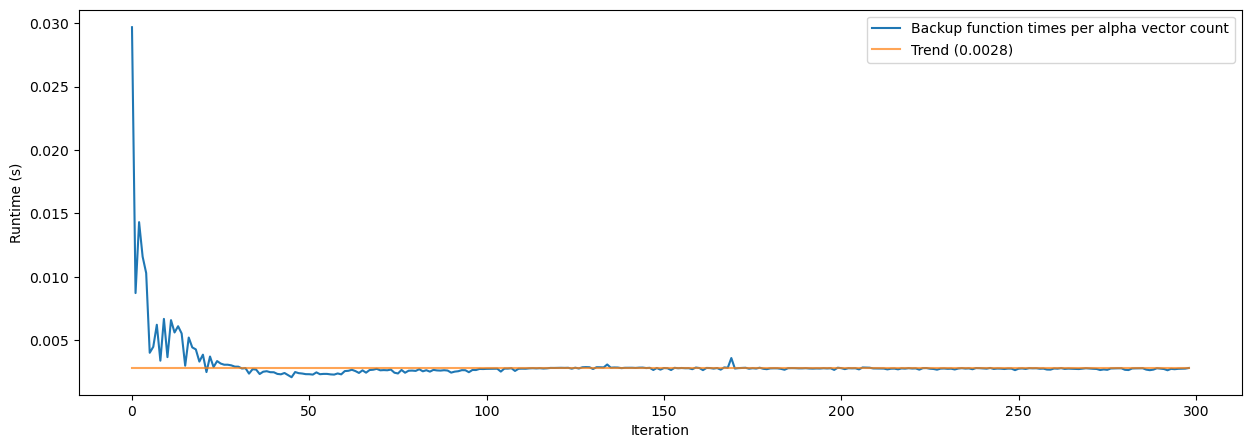

In [109]:
plt.figure(figsize=(15,5))

x = np.arange(299)

plt.plot(x, np.array(cpu_backup_times)[1:] / np.array(cpu_alpha_vector_counts[1:-1]), label='Backup function times per alpha vector count')

trend_1 = np.polyfit(x[100:290], (np.array(cpu_backup_times)[1:] / np.array(cpu_alpha_vector_counts[1:-1]))[100:290], 1)
plt.plot(x, np.ones(len(x)) * trend_1[1], alpha=0.7, label=f'Trend ({trend_1[1]:.4f})')

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Runtime (s)')

# Loading fsvi solution

In [13]:
fsvi_solution = ValueFunction.load_from_file('./ValueFunctions/20231115_fsvi_g0.99_i300_e100_value_function_wrap.csv.gzip', model).to_gpu()

[11/17/2023, 17:31:32] Sending Model to GPU...
[11/17/2023, 17:31:32]     > Done in 0.228s


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


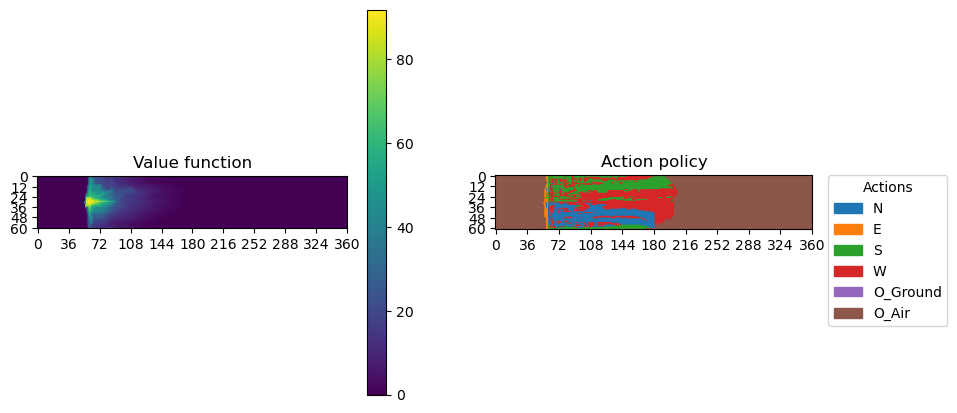

In [14]:
fsvi_solution.plot()

# Single sim

In [17]:
a = Agent(model=model, value_function=fsvi_solution)

In [18]:
hist = a.simulate()

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 1.18951
	- Steps: 23
	- Total rewards: 1.0
	- End state: s_30_60


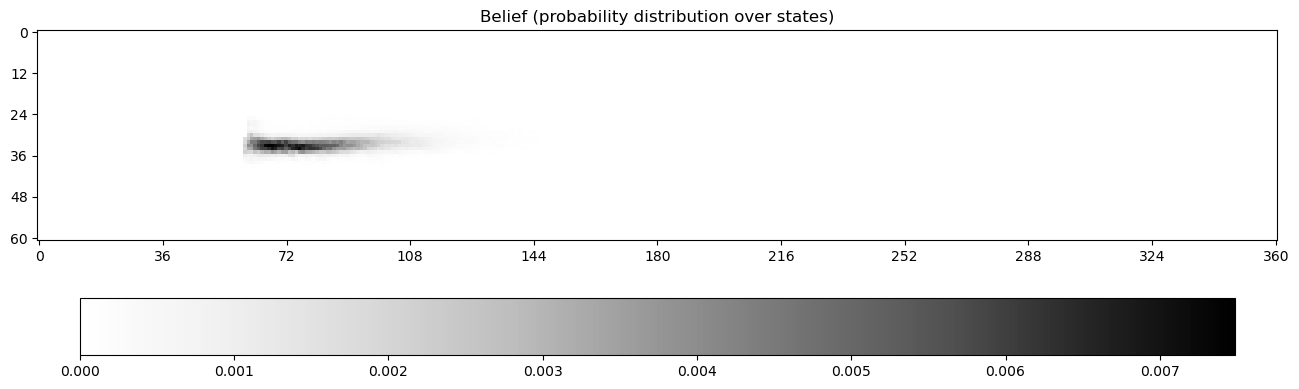

In [42]:
belief = hist.beliefs[8]

dimensions = model.state_grid.shape
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

plt.figure(figsize=(16,5))

plt.xticks(x_ticks)
plt.yticks(y_ticks)

# Title
plt.title(f'Belief (probability distribution over states)')

# Actual plot
belief_values = belief._values
grid_values = belief_values[model.state_grid]
plt.imshow(grid_values,cmap='Greys')
plt.colorbar(orientation='horizontal')

# Sim

In [14]:
a = Agent(model=model, value_function=fsvi_solution)

In [15]:
rew, all_sims = a.run_n_simulations_parallel(n=300, start_state=[(env_shape[1]*30)+300, (env_shape[1]*15)+300, (env_shape[1]*45)+300])

ValueError: cupy.ndaray cannot be specified as `repeats` argument.

In [51]:
sim_hist = a.simulate(start_state=(env_shape[1]*30)+300)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 0.975583
	- Steps: 556
	- Total rewards: 1.0
	- End state: s_30_60


In [17]:
# sim_hist.save()

Folder does not exist yet, creating it...
[Warning] Beliefs not saved with simulation history but the belief sequence can be recreated from the actions and observations.


In [23]:
# sim_hist.save_simulation_video()

Video saved at 'Sim Videos/s22021-a6-20231115_170540.mp4'...


# Sim plot

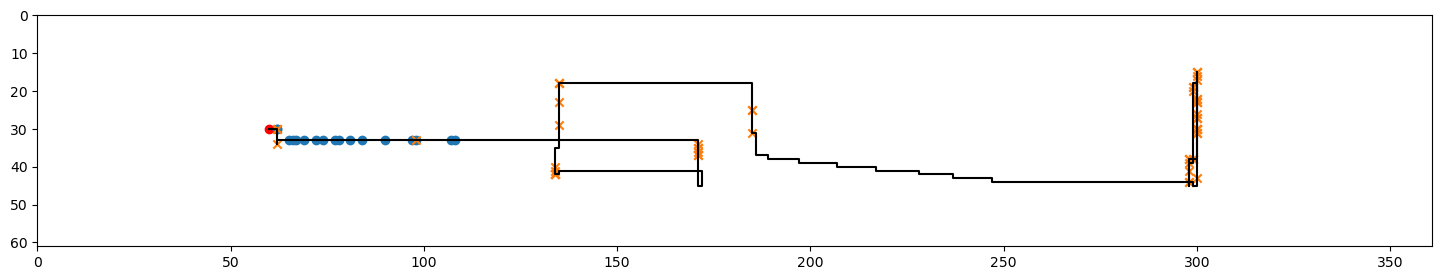

In [52]:
# PLot setup
plt.figure(figsize=(18,3))
plt.xlim(0, env_shape[1])
plt.ylim(env_shape[0], 0)


# Goal
plt.scatter(60, 30, c='red')

# Path
seq = np.array(sim_hist.grid_point_sequence)
plt.plot(seq[:,1], seq[:,0], c='black')

# Something sensed
obs_ts = np.where(np.array(sim_hist.observations) == 1)
points_obs = seq[obs_ts[0],:]
plt.scatter(points_obs[:,1], points_obs[:,0])

# Points sniff
sniff_in_air = np.where(np.array(sim_hist.actions) == 5)
points_sniff = seq[sniff_in_air[0],:]
plt.scatter(points_sniff[:,1], points_sniff[:,0], marker='x')

plt.show()

# Entropy-value plot

In [53]:
from scipy.stats import entropy

In [58]:
ents = [entropy(cp.asnumpy(b.values)) for b in sim_hist.beliefs]

In [59]:
b_array = cp.array([(b.values) for b in sim_hist.beliefs])
b_vals = cp.asnumpy(cp.max(cp.matmul(fsvi_solution.alpha_vector_array, b_array.T), axis=0))

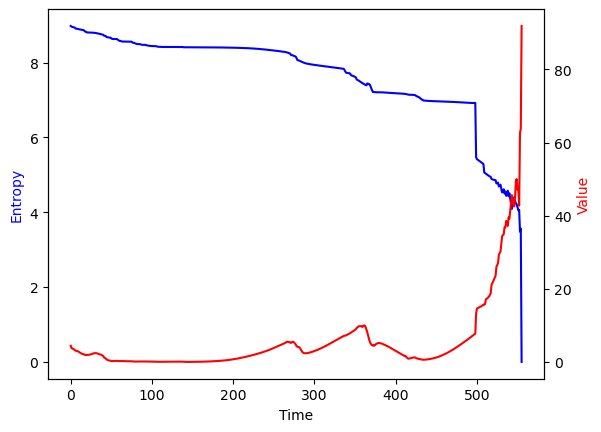

In [60]:
def plot_d(ax):
    ax.set_xlabel('Time')

    # Entropy
    ax.plot(np.arange(len(ents)), ents, color='blue')
    ax.set_ylabel('Entropy', color='blue')

    ax2 = ax.twinx()

    # Value
    ax2.plot(np.arange(len(b_vals)), b_vals, color='red')
    ax2.set_ylabel('Value', color='red')

fig, ax1 = plt.subplots()
plot_d(ax1)
plt.show()

# Multiple simulations

In [17]:
a = Agent(model, fsvi_solution)

In [18]:
# On center line
_, center_sim_set = a.run_n_simulations(n=100, start_state=(env_shape[1]*30)+300)

  0%|          | 0/100 [00:00<?, ?it/s]

All 100 simulations done:
	- Average runtime (s): 0.65314912
	- Average step count: 489.37
	- Average total rewards: 1.0
	- Average discounted rewards (ADR): 0.008675551195592105


In [19]:
# above center line
_, above_sim_set = a.run_n_simulations(n=100, start_state=(env_shape[1]*15)+300)

  0%|          | 0/100 [00:00<?, ?it/s]

All 100 simulations done:
	- Average runtime (s): 0.77953574
	- Average step count: 464.66
	- Average total rewards: 1.0
	- Average discounted rewards (ADR): 0.009959099381287312


In [20]:
# below center line
_, below_sim_set = a.run_n_simulations(n=100, start_state=(env_shape[1]*45)+300)

  0%|          | 0/100 [00:00<?, ?it/s]

All 100 simulations done:
	- Average runtime (s): 0.76489883
	- Average step count: 450.46
	- Average total rewards: 1.0
	- Average discounted rewards (ADR): 0.01203123595958547


In [21]:
sim_set = center_sim_set + above_sim_set + below_sim_set

# Res df

In [22]:
res_df = pd.DataFrame()

# Extra steps needed

In [23]:
sim_lengths = [len(sim) for sim in sim_set]

In [24]:
opt_traj = np.ones(300) * 240
opt_traj[100:] += 15

In [25]:
res_df['Steps'] = sim_lengths
res_df['Extra Steps'] = np.array(sim_lengths) - opt_traj

In [71]:
# Ground sim res
ground_res_df = pd.read_csv('./Results/res_300it_alt_paper_wrap_ground_only.csv')
ground_extra_steps = ground_res_df['Extra Steps'].to_numpy()

In [76]:
len(np.where(ground_res_df['Steps'].to_numpy() < 1000)[0])

210

In [78]:
ground_extra_steps_filtered = np.empty(300)
ground_extra_steps_filtered[:210] = ground_extra_steps[np.where(ground_res_df['Steps'].to_numpy() < 1000)[0]]

In [79]:
# Combine it all in a df
extra_steps_df = pd.DataFrame({
    'Ground and Air': np.array(sim_lengths) - opt_traj,
    'Ground only': ground_extra_steps_filtered
})

In [82]:
ground_extra_steps[np.where(ground_res_df['Steps'].to_numpy() < 1000)[0]]

array([102., 104., 117.,  77., 114.,  90., 101.,  91., 103.,  91.,  93.,
        89.,  87.,  95., 107.,  93., 124., 121.,  99.,  99.,  88., 109.,
       105.,  87., 195.,  99., 103., 117.,  91., 185.,  87., 104., 101.,
        91.,  88.,  91.,  92., 104.,  92., 105., 130.,  90., 102.,  91.,
       115.,  91., 104., 103., 115.,  89.,  90.,  95., 138.,  91.,  99.,
        98., 109.,  93., 104.,  91., 108.,  86., 121.,  90.,  91.,  77.,
       107., 104., 104., 101.,  96.,  89.,  87.,  90.,  91., 107., 120.,
       105., 131., 107., 113.,  94.,  99.,  97.,  90.,  93., 133.,  95.,
       105.,  97., 111., 131., 197.,  91.,  89.,  99.,  99., 179., 177.,
       122., 115.,  93., 211., 107.,  90., 109., 113., 135., 181., 139.,
       105., 129.,  99., 159., 109., 107., 103., 135., 116.,  94., 147.,
       105., 107., 163., 131., 109.,  95., 181., 128., 103., 165.,  99.,
       101., 115., 269., 139., 257., 129., 135., 269., 113., 116., 156.,
       169., 111., 113., 104.,  67., 115.,  69.,  7

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8f203369d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8f20337dd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8f204cb610>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8f20344d10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8edad8d390>],
 'means': []}

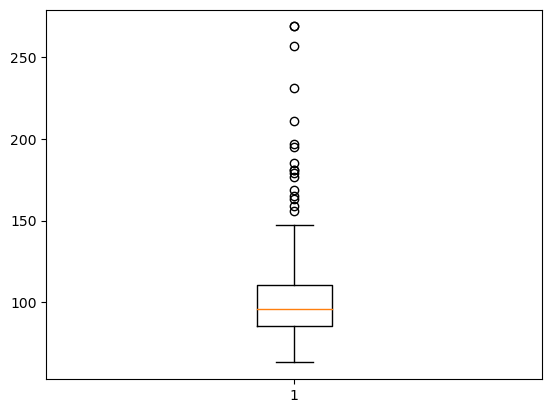

In [81]:
plt.boxplot(ground_extra_steps[np.where(ground_res_df['Steps'].to_numpy() < 1000)[0]])

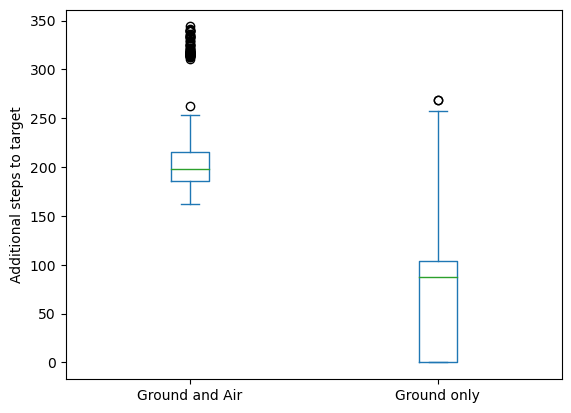

In [80]:
def plot_b(ax):
    ax.set_ylabel('Additional steps to target')

    extra_steps_df.plot(kind='box', ax=ax)

fig, ax1 = plt.subplots()
plot_b(ax1)
plt.show()

# Sniff in air clos vs far

In [39]:
close_points = np.where(nose_data.ravel() > 0)[0]

In [40]:
close_rates = []
far_rates = []
for sim in sim_set:
    close_sniff_air = 0
    close_steps = 0

    far_sniff_air = 0
    far_steps = 0
    for s,a in zip(sim.states[1:], sim.actions):
        if s in close_points:
            close_steps += 1
            if a == 5:
                close_sniff_air +=1
        else:
            far_steps += 1
            if a == 5:
                far_sniff_air += 1

    close_rates.append(close_sniff_air / close_steps)
    far_rates.append(far_sniff_air / far_steps)

In [41]:
res_df['Close Sniff Rate'] = np.array(close_rates)
res_df['Far Sniff Rate'] = np.array(far_rates)

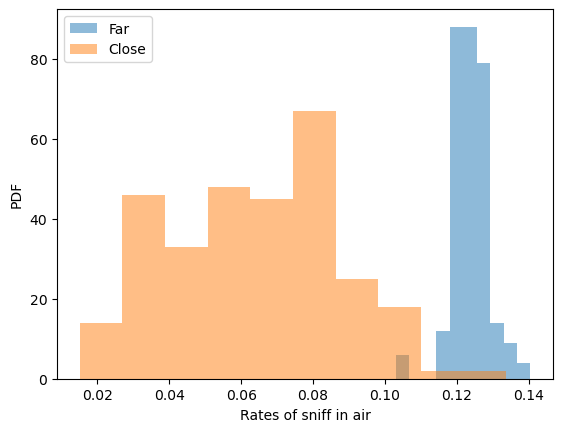

In [42]:
def plot_a(ax):
    ax.set_ylabel('PDF')
    ax.set_xlabel('Rates of sniff in air')

    ax.hist(far_rates, alpha=0.5, label='Far')
    ax.hist(close_rates, alpha=0.5, label='Close')
    ax.legend()

fig, ax1 = plt.subplots()
plot_a(ax1)
plt.show()

# Cast/surge rates

In [43]:
surge_rates = []
cast_rates = []

for sim in sim_set:

    # Cast action: 0 or 2
    is_action = np.where((np.array(sim.actions) == 0) | (np.array(sim.actions) == 2) | (np.array(sim.actions) == 5), 1, 0)
    is_action_seq = is_action[:-2] + is_action[1:-1] + is_action[2:]
    cast_sequence = np.zeros(len(sim), dtype=bool)

    for i, el in enumerate(is_action_seq):
        if el == 3:
            cast_sequence[i:i+3] = True

    cast_count = np.sum(cast_sequence[:-1])
    cast_sniff = np.sum(cast_sequence[:-1] & (np.array(sim.actions) == 5))
    cast_rates.append(cast_sniff / cast_count)

    # Surge action: 3
    is_action = np.where((np.array(sim.actions) == 3) | (np.array(sim.actions) == 5), 1, 0)
    is_action_seq = is_action[:-2] + is_action[1:-1] + is_action[2:]
    surge_sequence = np.zeros(len(sim), dtype=bool)

    for i, el in enumerate(is_action_seq):
        if el == 3:
            surge_sequence[i:i+3] = True

    surge_count = np.sum(surge_sequence[:-1])
    surge_sniff = np.sum(surge_sequence[:-1] & (np.array(sim.actions) == 5))
    surge_rates.append(surge_sniff / surge_count)

In [44]:
res_df['Surge Sniff Rate'] = np.array(surge_rates)
res_df['Cast Sniff Rate'] = np.array(cast_rates)

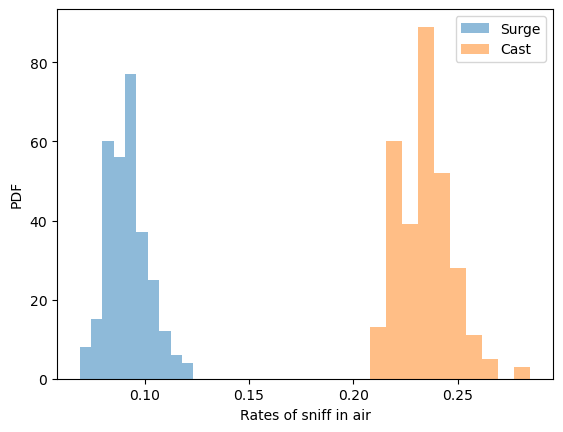

In [45]:
def plot_c(ax):
    ax.set_ylabel('PDF')
    ax.set_xlabel('Rates of sniff in air')
    
    ax.hist(surge_rates, alpha=0.5, label='Surge')
    ax.hist(cast_rates, alpha=0.5, label='Cast')
    ax.legend()

fig, ax1 = plt.subplots()
plot_c(ax1)
plt.show()

# Combined graph

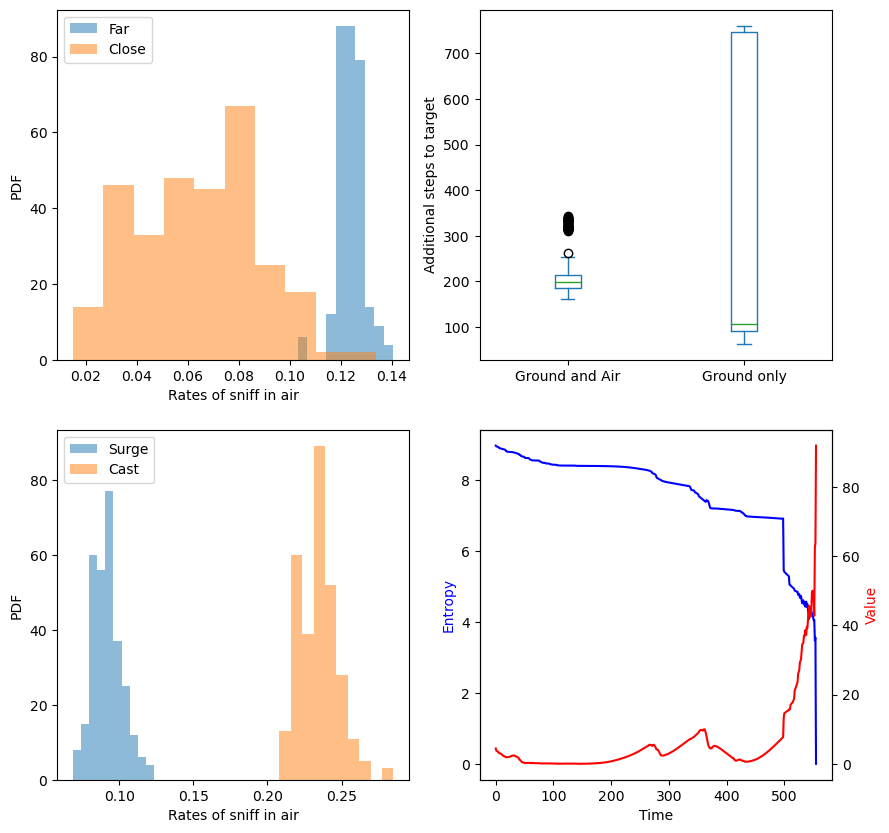

In [61]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2, figsize=(10,10))

plot_a(ax0)
plot_b(ax1)
plot_c(ax2)
plot_d(ax3)

plt.show()

# Save res

In [62]:
res_df.to_csv('./Results/res_300it_alt_paper_wrap.csv')